<a href="https://colab.research.google.com/github/jaggu24/QA-System/blob/main/QA_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the Data

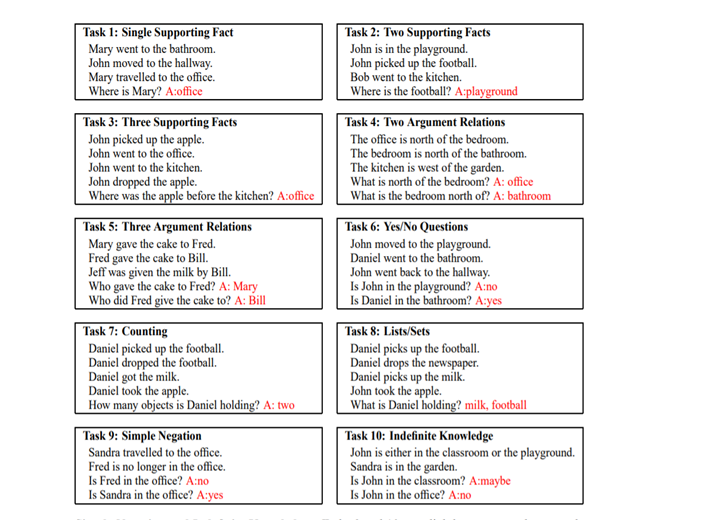

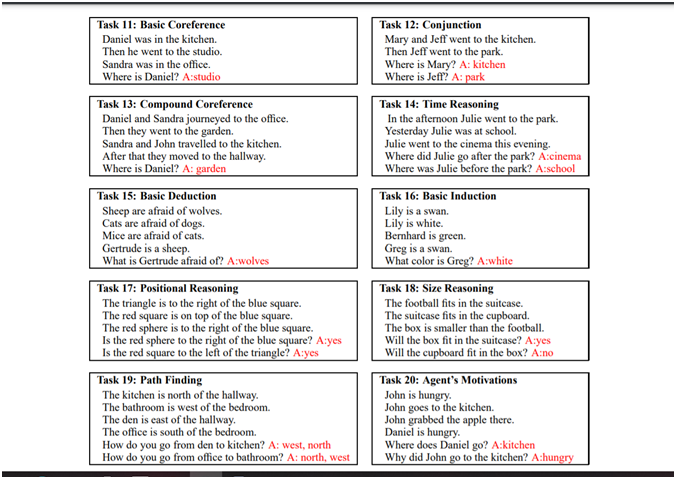

# 4 Daniel went back to the hallway.
# 5 Sandra moved to the garden.
# 6 Where is Daniel?      hallway 4

In [ ]:
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.utils.data_utils import get_file
import collections
import itertools
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import tarfile
from functools import reduce


In [ ]:
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar = tarfile.open(path)

11747328/11745123 [==============================] - 1s 0us/step


In [ ]:
task = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
print('Challenge: Single Supporting Fact')
train_stories =(tar.extractfile(task.format('train')))
test_stories = (tar.extractfile(task.format('test')))
print(list(train_stories))

Challenge: Single Supporting Fact
[b'1 Mary moved to the bathroom.\n', b'2 John went to the hallway.\n', b'3 Where is Mary? \tbathroom\t1\n', b'4 Daniel went back to the hallway.\n', b'5 Sandra moved to the garden.\n', b'6 Where is Daniel? \thallway\t4\n', b'7 John moved to the office.\n', b'8 Sandra journeyed to the bathroom.\n', b'9 Where is Daniel? \thallway\t4\n', b'10 Mary moved to the hallway.\n', b'11 Daniel travelled to the office.\n', b'12 Where is Daniel? \toffice\t11\n', b'13 John went back to the garden.\n', b'14 John moved to the bedroom.\n', b'15 Where is Sandra? \tbathroom\t8\n', b'1 Sandra travelled to the office.\n', b'2 Sandra went to the bathroom.\n', b'3 Where is Sandra? \tbathroom\t2\n', b'4 Mary went to the bedroom.\n', b'5 Daniel moved to the hallway.\n', b'6 Where is Sandra? \tbathroom\t2\n', b'7 John went to the garden.\n', b'8 John travelled to the office.\n', b'9 Where is Sandra? \tbathroom\t2\n', b'10 Daniel journeyed to the bedroom.\n', b'11 Daniel travelle

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
class QA_Sysyem:
  def __init__(self,tar):
    self.tar = tar 

  def tokenize(self,sent):
    return word_tokenize(sent)
 
  def parse_stories(self,lines):
      data = []
      story = []
      for line in lines:
          line = line.decode('utf-8').strip()
          nid, line = line.split(' ', 1)
          nid = int(nid)
          if nid == 1:
              story = []
          if '\t' in line:
              q, a, supporting = line.split('\t')
              q = self.tokenize(q)
              substory = [x for x in story if x]
              data.append((substory, q, a))
              story.append('')
          else:
              sent = self.tokenize(line)
              story.append(sent)
      return data

  def get_stories(self,f):
      data = self.parse_stories(f.readlines())
      flatten = lambda data: reduce(lambda x, y: x + y, data)
      data = [(flatten(story), q, answer) for story, q, answer in data]
      return data

  def retrive_task(self):
    self.challenge = 'tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_{}.txt'
    print('Extracting stories for the challenge: qa6_yes-no-questions')
    self.train_stories = self.get_stories(self.tar.extractfile(self.challenge.format('train')))
    self.test_stories = self.get_stories(self.tar.extractfile(self.challenge.format('test')))
    print('Number of training stories:', len(self.train_stories))
    print('Number of test stories:', len(self.test_stories))
    print(self.train_stories[4])

  def vectorize_stories(self,data, word_idx, story_maxlen, query_maxlen):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))


  def trainModel(self):
    self.vocab = set()
    for story, q, answer in self.train_stories + self.test_stories:
        self.vocab |= set(story + q + [answer])
    self.vocab = sorted(self.vocab)
    self.vocab_size = len(self.vocab) + 1
    self.story_maxlen = max(map(len, (x for x, _, _ in self.train_stories + self.test_stories)))
    self.query_maxlen = max(map(len, (x for _, x, _ in self.train_stories + self.test_stories)))
    self.word_idx = dict((c, i + 1) for i, c in enumerate(self.vocab))
    self.inputs_train, self.queries_train, self.answers_train = self.vectorize_stories(self.train_stories,
                                                                  self.word_idx,
                                                                  self.story_maxlen,
                                                                  self.query_maxlen)
    self.inputs_test, self.queries_test, self.answers_test = self.vectorize_stories(self.test_stories,
                                                                self.word_idx,
                                                                self.story_maxlen,
                                                            self.query_maxlen)
    print('-------------------------')
    print('Vocabulary:\n',self.vocab,"\n")
    print('Vocab size:', self.vocab_size, 'unique words')
    print('Story max length:', self.story_maxlen, 'words')
    print('Query max length:', self.query_maxlen, 'words')
    print('Number of training stories:', len(self.train_stories))
    print('Number of test stories:', len(self.test_stories))
    print('-------------------------')

  def init_training(self):
    self.train_epochs = 100
    self.batch_size = 32
    self.embed_size = 50
    self.lstm_size = 64
    self.dropout_rate = 0.30
    self.input_sequence = Input((self.story_maxlen,))
    self.question = Input((self.query_maxlen,))
    print('Input sequence:', self.input_sequence)
    print('Question:', self.question)
    
    self.input_encoder_m = Sequential()
    self.input_encoder_m.add(Embedding(input_dim=self.vocab_size,
                                  output_dim=self.embed_size))
    self.input_encoder_m.add(Dropout(self.dropout_rate)) 
    self.input_encoder_c = Sequential()
    self.input_encoder_c.add(Embedding(input_dim=self.vocab_size,
                                  output_dim=self.query_maxlen))
    self.input_encoder_c.add(Dropout(self.dropout_rate))
    
    self.question_encoder = Sequential()
    self.question_encoder.add(Embedding(input_dim=self.vocab_size,
                                  output_dim=self.embed_size,
                                  input_length=self.query_maxlen))
    self.question_encoder.add(Dropout(self.dropout_rate))
    
    # to sequences of dense vectors
    self.input_encoded_m = self.input_encoder_m(self.input_sequence)
    print('Input encoded m', self.input_encoded_m)
    self.input_encoded_c = self.input_encoder_c(self.input_sequence)
    print('Input encoded c', self.input_encoded_c)
    self.question_encoded = self.question_encoder(self.question)
    print('Question encoded', self.question_encoded)
    
    self.match = dot([self.input_encoded_m, self.question_encoded], axes=-1, normalize=False)
    print(self.match.shape)
    self.match = Activation('softmax')(self.match)
    print('Match shape',self. match)
    
    self.response = add([self.match, self.input_encoded_c]) 
    self.response = Permute((2, 1))(self.response)  
    print('Response shape', self.response)
    
    self.answer = concatenate([self.response, self.question_encoded])
    print('Answer shape', self.answer)
    
    self.answer = LSTM(self.lstm_size)(self.answer)  
    self.answer = Dropout(self.dropout_rate)(self.answer)
    self.answer = Dense(self.vocab_size)(self.answer)
    self.answer = Activation('softmax')(self.answer)
  
  def build_model(self):
    self.model = Model([self.input_sequence, self.question], self.answer)
    self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(self.model.summary())

  def train_model(self):
    self.history = self.model.fit([self.inputs_train, self.queries_train], self.answers_train, 
                        batch_size=self.batch_size, 
                        epochs=self.train_epochs,
                        validation_data=([self.inputs_test, self.queries_test], self.answers_test))
    #model.save('model.h5')

  def plotmodelhistory(self): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize self.history for accuracy
    axs[0].plot(self.history.history['accuracy']) 
    axs[0].plot(self.history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(self.history.history['loss']) 
    axs[1].plot(self.history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()
    print(self.history.history.keys())


In [ ]:
instance=QA_Sysyem(tar)

In [ ]:
instance.retrive_task()

Extracting stories for the challenge: qa6_yes-no-questions
Number of training stories: 10000
Number of test stories: 1000
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.', 'Mary', 'went', 'back', 'to', 'the', 'bedroom', '.', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.', 'Sandra', 'went', 'to', 'the', 'kitchen', '.', 'Daniel', 'went', 'back', 'to', 'the', 'bathroom', '.', 'Daniel', 'picked', 'up', 'the', 'football', 'there', '.', 'Daniel', 'went', 'to', 'the', 'bedroom', '.', 'John', 'travelled', 'to', 'the', 'office', '.', 'Sandra', 'went', 'to', 'the', 'garden', '.'], ['Is', 'Daniel', 'in', 'the', 'bedroom', '?'], 'yes')


In [ ]:
instance.trainModel()

-------------------------
Vocabulary:
 ['.', '?', 'Daniel', 'Is', 'John', 'Mary', 'Sandra', 'apple', 'back', 'bathroom', 'bedroom', 'discarded', 'down', 'dropped', 'football', 'garden', 'got', 'grabbed', 'hallway', 'in', 'journeyed', 'kitchen', 'left', 'milk', 'moved', 'no', 'office', 'picked', 'put', 'the', 'there', 'to', 'took', 'travelled', 'up', 'went', 'yes'] 

Vocab size: 38 unique words
Story max length: 156 words
Query max length: 6 words
Number of training stories: 10000
Number of test stories: 1000
-------------------------


In [ ]:
instance.init_training()

Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 156), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 156, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 156, 6), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 6, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")
(None, 156, 6)
Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 156, 6), dtype=tf.float32, name=None), name='act

In [ ]:
instance.build_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 50)     1900        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 6, 50)        1900        input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
instance.train_model()

Epoch 1/100
313/313 [==============================] - 35s 12ms/step - loss: 0.9931 - accuracy: 0.4934 - val_loss: 0.6959 - val_accuracy: 0.4970
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.7034 - accuracy: 0.4909 - val_loss: 0.6939 - val_accuracy: 0.4970
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6946 - accuracy: 0.5119 - val_loss: 0.6936 - val_accuracy: 0.4950
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6961 - accuracy: 0.4875 - val_loss: 0.6950 - val_accuracy: 0.4970
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6935 - accuracy: 0.5096 - val_loss: 0.7011 - val_accuracy: 0.5030
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6953 - accuracy: 0.4998 - val_loss: 0.6944 - val_accuracy: 0.4800
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6925 - accuracy: 0.5068 - val_loss: 0.6933 - val_accuracy: 0.51

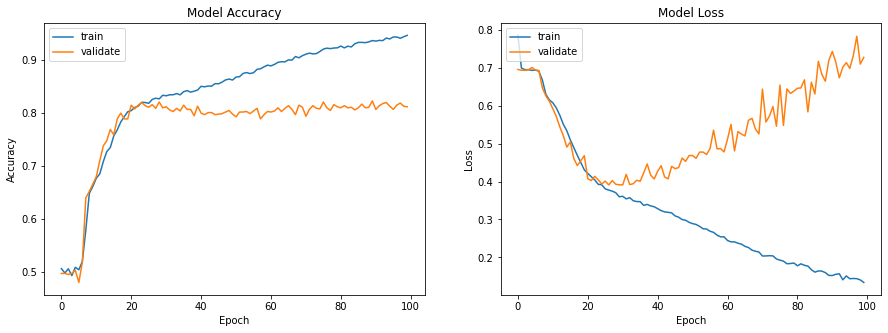

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
instance.plotmodelhistory()

In [ ]:
idx_word = dict((i+1, c) for i,c in enumerate(instance.vocab))
for i in range(0,30):
    current_inp = instance.test_stories[i]
    current_story, current_query, current_answer = instance.vectorize_stories([current_inp], instance.word_idx, instance.story_maxlen, instance.query_maxlen)
    current_prediction = instance.model.predict([current_story, current_query])
    current_prediction = idx_word[np.argmax(current_prediction)]
    print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
    print("--------------------------------------------------------------")

Mary got the milk there . John moved to the bedroom . Is John in the kitchen ? | Prediction: no | Ground Truth: no
--------------------------------------------------------------
Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden . Is John in the kitchen ? | Prediction: no | Ground Truth: no
--------------------------------------------------------------
Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden . Daniel moved to the bedroom . Daniel went to the garden . Is John in the garden ? | Prediction: no | Ground Truth: yes
--------------------------------------------------------------
Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden . Daniel moved to the bedroom . Daniel went to the garden . Daniel travelled to the bathroom . Sandra travelled to the bedroom . Is Daniel in the bathroom ? | Prediction: yes | Ground Truth: yes
-----

In [ ]:
3+8

11